In [27]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte, color
from skimage.transform import resize
from skimage.segmentation import find_boundaries
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from keras.layers import Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
import cv2
import os
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
from skimage.transform import resize
from skimage import color
from PIL import Image
import pandas as pd

In [2]:

# Enable eager execution for TensorFlow
tf.config.run_functions_eagerly(True)


## Constants

In [3]:
# IMG_WIDTH = 384
# IMG_HEIGHT = 256
IMG_WIDTH = 224
IMG_HEIGHT = IMG_WIDTH
IMG_CHANNELS = 3

## Util functions

In [4]:
def display_results(original_img, processed_img, segmentation_mask, figsize=(10, 5)):
    """
    Display four images:
    1. Original image
    2. Preprocessed image
    3. Segmentation mask
    4. Processed image with segmentation border overlay
    
    Parameters:
    - original_img: The original input image (numpy array)
    - processed_img: The preprocessed image (numpy array)
    - segmentation_mask: The predicted segmentation mask (numpy array)
    - figsize: Tuple specifying the figure size (width, height) in inches
    """
    # Create the figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Display original image
    axes[0][0].imshow(original_img)
    axes[0][0].set_title('Original Image')
    axes[0][0].axis('off')
    
    # Display preprocessed image
    axes[0][1].imshow(processed_img)
    axes[0][1].set_title('Preprocessed Image')
    axes[0][1].axis('off')
    
    # Display segmentation mask
    axes[1][1].imshow(segmentation_mask, cmap='gray')
    axes[1][1].set_title('Segmentation Mask')
    axes[1][1].axis('off')
    
    # Resize segmentation mask to match processed image dimensions
    mask_resized = resize(segmentation_mask, 
                         (processed_img.shape[0], processed_img.shape[1]),
                         preserve_range=True,
                         anti_aliasing=False)
    mask_resized = mask_resized > 0.5  # Binarize again after resize
    
    # Create and display border overlay on PROCESSED IMAGE
    borders = find_boundaries(mask_resized, mode='inner')
    overlay = processed_img.copy()
    
    # Handle both grayscale and color images
    if len(overlay.shape) == 2:  # Grayscale
        overlay = color.gray2rgb(overlay)
    
    # Set border pixels to red
    overlay[borders] = [0, 255, 0]  # Highlight borders in red
    
    axes[1][0].imshow(overlay)
    axes[1][0].set_title('Border Overlay on Processed Image')
    axes[1][0].axis('off')
    
    plt.tight_layout()
    plt.show()

## Defining model

In [18]:

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer='he_normal', padding='same')(input_tensor)
    # x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
    #            kernel_initializer='he_normal', padding='same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def get_unet(input_img, n_filters=16, dropout=0.1, batchnorm=True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


## Processing pipeline

In [19]:
def preprocess_image(image_path):
    """Preprocess the input image for segmentation"""
    # Read and resize image
    img = io.imread(image_path)[:, :, :IMG_CHANNELS]
    img_resized = resize(img, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True).astype(np.uint8)
    
    # Convert to grayscale and apply blackhat
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    
    # Threshold and inpaint
    _, thresh = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    inpainted = cv2.inpaint(img_resized, thresh, 1, cv2.INPAINT_TELEA)
    
    # Apply Gaussian blur
    final_img = cv2.GaussianBlur(inpainted, (7, 7), 0)
    
    return img_resized, final_img


In [20]:
def predict_mask(image_path, model):
    """Load image and predict segmentation mask"""
    # Preprocess image
    img_resized, processed_img = preprocess_image(image_path)
    
    # Prepare input for model
    X_test = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    X_test[0] = img_resized
    
    # Predict
    predicted = model.predict(X_test, verbose=1)
    predicted_mask = (predicted > 0.5).astype(bool)
    
    return processed_img, predicted_mask.squeeze()



## Load the model

In [21]:
input_img = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.load_weights('../models/model-skin-lesion-segmentation-org2000.h5')

## Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_228']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


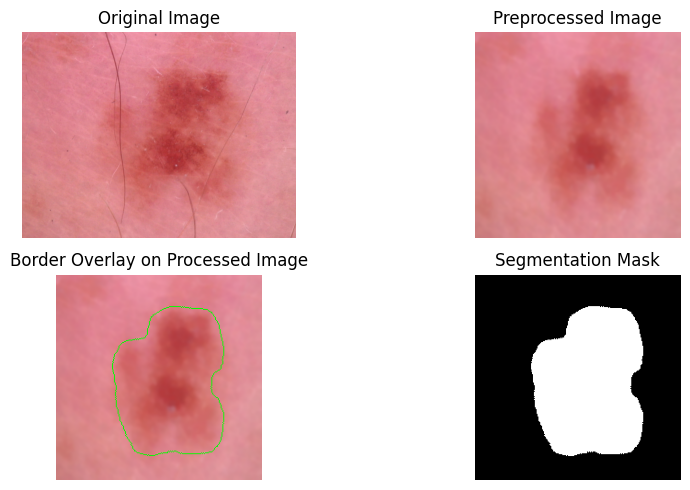

In [22]:
image_path = "../data/test/ISIC_0024307.jpg" 
original_img = io.imread(image_path)
processed_img, segmentation_mask = predict_mask(image_path, model)
display_results(original_img, processed_img, segmentation_mask)

## Process whole folder

In [23]:
def process_image(src_path, dest_path):
    try:
        _, segmentation_mask = predict_mask(src_path, model)
        mask_img = Image.fromarray((segmentation_mask * 255).astype(np.uint8))
        mask_img.save(dest_path)
    except Exception as e:
        print(f"Error processing {src_path}: {e}")

In [24]:
process_image('../data/test/ISIC_0024307.jpg', '../data/masks_train/ISIC_0024306.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_228']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


In [32]:
def process_image_batch(
    csv_file: str,
    image_dir: str,
    output_dir: str
) -> None:
    """
    Processes and saves images into 'benign' and 'malignant'
    folders based on labels from CSV file.

    Applies optional preprocessing, resizes images, and saves them
    into categorized folders using multiprocessing.

    Args:
        csv_file (str): Path to CSV with image names and labels.
        image_dir (str): Directory containing input images.
        output_dir (str): Destination directory for processed images.
        image_size (Tuple[int, int]): Target size (width, height) for output images.
        padding_flag (bool): Add padding to preserve aspect ratio if True.
        apply_clahe_flag (bool): Apply CLAHE if True.
        remove_hair_flag (bool): Apply hair removal preprocessing if True.
    """
    df = pd.read_csv(csv_file)
    df["image_name"] = df["image_name"] + ".jpg"

    dest_dir = os.path.join(output_dir, "segmentation_mask")
    os.makedirs(dest_dir, exist_ok=True)

    for _, row in df.iterrows():
        src_path = os.path.join(image_dir, row["image_name"])
        dest_path = os.path.join(dest_dir, row["image_name"])
        process_image(src_path, dest_path)


In [33]:
csv_file = '../data/test_truth.csv'
image_dir = '../data/test/'
output_dir = '../data/masks_train/'
process_image_batch(csv_file, image_dir, output_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_228']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_228']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_228']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_228']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_228']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_228']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/mipopovic/Desktop/Skin-Lesion-Segmentation-Classification/venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_228']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
